In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgbm
from lightgbm import early_stopping
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit, GroupKFold
from scipy.stats import skew, kurtosis
import polars as pl
import warnings
warnings.filterwarnings('ignore')

In [8]:
df = pd.read_csv("train.csv")
df.to_pickle("train.pkl")

In [9]:
def load_data():
    train = pd.read_pickle('train.pkl')
    test = pd.read_csv('./example_test_files/test.csv')
    revealed_targets = pd.read_csv('./example_test_files/revealed_targets.csv')
    
    return train, test, revealed_targets

train, test, revealed_targets = load_data()

print(f"Train Shape: {train.shape}")
print(f"Test Shape: {test.shape}")
print(f"Revealed Targets Shape: {revealed_targets.shape}")

train.info()
train.describe().T

Train Shape: (5237980, 17)
Test Shape: (33000, 17)
Revealed Targets Shape: (33162, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5237980 entries, 0 to 5237979
Data columns (total 17 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   stock_id                 int64  
 1   date_id                  int64  
 2   seconds_in_bucket        int64  
 3   imbalance_size           float64
 4   imbalance_buy_sell_flag  int64  
 5   reference_price          float64
 6   matched_size             float64
 7   far_price                float64
 8   near_price               float64
 9   bid_price                float64
 10  bid_size                 float64
 11  ask_price                float64
 12  ask_size                 float64
 13  wap                      float64
 14  target                   float64
 15  time_id                  int64  
 16  row_id                   object 
dtypes: float64(11), int64(5), object(1)
memory usage: 679.4+ MB


,count,mean,std,min,25%,50%,75%,max
stock_id,5237980.0,9.928856e+01,5.787176e+01,0.000000,4.900000e+01,9.900000e+01,1.490000e+02,1.990000e+02
date_id,5237980.0,2.415100e+02,1.385319e+02,0.000000,1.220000e+02,2.420000e+02,3.610000e+02,4.800000e+02
seconds_in_bucket,5237980.0,2.700000e+02,1.587451e+02,0.000000,1.300000e+02,2.700000e+02,4.100000e+02,5.400000e+02
imbalance_size,5237760.0,5.715293e+06,2.051591e+07,0.000000,8.453415e+04,1.113604e+06,4.190951e+06,2.982028e+09
imbalance_buy_sell_flag,5237980.0,-1.189619e-02,8.853374e-01,-1.000000,-1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
reference_price,5237760.0,9.999955e-01,2.532497e-03,0.935285,9.987630e-01,9.999670e-01,1.001174e+00,1.077488e+00
matched_size,5237760.0,4.510025e+07,1.398413e+08,4316.610000,5.279575e+06,1.288264e+07,3.270013e+07,7.713682e+09
far_price,2343638.0,1.001713e+00,7.214705e-01,0.000077,9.963320e-01,9.998830e-01,1.003318e+00,4.379531e+02
near_price,2380800.0,9.996601e-01,1.216920e-02,0.786988,9.971000e-01,9.998890e-01,1.002590e+00,1.309732e+00
bid_price,5237760.0,9.997263e-01,2.499345e-03,0.934915,9.985290e-01,9.997280e-01,1.000905e+00,1.077488e+00


Notes on input data
* Roughly 200 total stocks. Treat as categorical
* 0-480 trading days. ~10,500 rows per date_id, but we have 200 stocks and 55 buckets = 11,000 rows. Dataset is not 100% complete.
* seconds_in_bucket 0 - 540. last 9 minutes. Uniformish spread. Encode as time_to_close = 600 - seconds_in_bucket. One snapshot every 10s
* imbalance_size - huge positve skew (75% 4.2M yet max > 2B). Log-1p transform and/or winsorise
* imbalance_buy_sell_flag. balanced directions. Keep as int. Maybe create interaction term with stock_id or time_to_close
* reference_price, bid/ask_price, wap all centered at 1.0000± 0.0025. Work with ratios
* far_price, near_price missing in >2.8M rows. The 437 value is a clear outlier (probably an empty auction band early in the day) → clip to, say, 1.05.
* matched_size. same skew as imbalance_size. Use log1p, create cumulative_match_pct = matched_size / (matched_size + imbalance_size)
* bid/ask_size = Depth imbalance and log-depth will be more predictive than raw size. Clip top 0.1 % or use log1p.
* Target (bp) = 99 % of rows lie in ±20 bp, yet extremes reach 40×σ.Use Huber / L1 loss or winsorise.

**Red flags**

Imbalance & size columns: fat-tailed γ-like distributions.
⇒ log1p, bucket-by-percentile, and interaction terms (e.g., huge imbalance * sign).

far_price 437: single-row glitch.
⇒ hard-cap at 1.05 and create far_price_capped_flag.

Target extremes: ≤ 0.2 % of rows but blow up MSE.
⇒ winsorise or use Huber δ=25 bp; keep raw for final metric.



In [29]:
missing = train.isnull().sum()
missing_pct = 100 * missing / len(train)

missing_summary = pd.DataFrame({
    'missing_count': missing,
    'missing_pct': missing_pct
}).sort_values('missing_count', ascending=False)

print(missing_summary)

                         missing_count  missing_pct
far_price                      2894342    55.256836
near_price                     2857180    54.547364
ask_price                          220     0.004200
imbalance_size                     220     0.004200
reference_price                    220     0.004200
matched_size                       220     0.004200
wap                                220     0.004200
bid_price                          220     0.004200
target                              88     0.001680
time_id                              0     0.000000
ask_size                             0     0.000000
stock_id                             0     0.000000
bid_size                             0     0.000000
date_id                              0     0.000000
imbalance_buy_sell_flag              0     0.000000
seconds_in_bucket                    0     0.000000
row_id                               0     0.000000


Missing-values
| column                            | non-null count | % missing  | comment                                                    |
| --------------------------------- | -------------- | ---------- | ---------------------------------------------------------- |
| `far_price`                       | 2.34 M         | **55 %**   | auction bands not yet published                            |
| `near_price`                      | 2.38 M         | **55 %**   | same                                                       |
| `reference_price`, `matched_size` | 5.237 M        | **<0.5 %** | occasional nulls—forward-fill within `(stock_id, date_id)` |
| others                            | 5.238 M        | \~0 %      | essentially complete                                       |


In [ ]:
def make_features(df):
    imb_map = {-1: 0, 0: 1, 1: 2}
    if 'imbalance_buy_sell_flag' in df.columns:
        df['imbalance_buy_sell_flag'] = df['imbalance_buy_sell_flag'].map(imb_map)
    df['imb_side_flag'] = df['imbalance_buy_sell_flag']

    df['signed_imbalance'] = (
        df['imbalance_buy_sell_flag'] * df['imbalance_size']
    )

    df['auc_bid_size'] = df['matched_size']
    df['auc_ask_size'] = df['matched_size']
    mask_buy  = df['imbalance_buy_sell_flag'] == 1
    mask_sell = df['imbalance_buy_sell_flag'] == -1
    df.loc[mask_buy,  'auc_bid_size'] += df.loc[mask_buy,  'imbalance_size']
    df.loc[mask_sell, 'auc_ask_size'] += df.loc[mask_sell, 'imbalance_size']

    # Price-Based Features
    df['spread'] = df['ask_price'] - df['bid_price']
    df['mid_price'] = (df['ask_price'] + df['bid_price']) / 2
    df['bid_ref_dist'] = df['reference_price'] - df['bid_price']
    df['ask_ref_dist'] = df['ask_price'] - df['reference_price']
    df['mid_ref_dist'] = df['reference_price'] - df['mid_price']
    df['bid_wap_delta'] = df['bid_price'] - df['wap']
    df['ask_wap_delta'] = df['ask_price'] - df['wap']
    df['ref_wap_delta'] = df['reference_price'] - df['wap']

    # Size-Based Features
    df['size_imbalance'] = df['bid_size'] - df['ask_size']
    df['size_ratio'] = (df['bid_size'] + 1) / (df['ask_size'] + 1)
    df['bid_size_norm'] = df['bid_size'] / (df['bid_size'] + df['ask_size'] + 1)
    df['ask_size_norm'] = df['ask_size'] / (df['bid_size'] + df['ask_size'] + 1)

    # Auction/Imbalance Features 
    df['rel_imbalance'] = df['imbalance_size'] / (df['matched_size'] + 1)
    df['rel_matched'] = df['matched_size'] / (df['bid_size'] + df['ask_size'] + 1)
    # Flag for direction of imbalance (after mapping: buy=2, sell=0)
    df['imbalance_is_buy'] = (df['imbalance_buy_sell_flag'] == 2).astype(int)
    df['imbalance_is_sell'] = (df['imbalance_buy_sell_flag'] == 0).astype(int)

    # Temporal Features 
    bucket_len=300
    df['seconds_remaining'] = bucket_len - df['seconds_in_bucket']
    df['last_10_seconds'] = (df['seconds_in_bucket'] >= (bucket_len - 10)).astype(int)
    df['ask_size_x_time'] = df['ask_size'] * df['seconds_in_bucket']
    df['bid_size_x_time'] = df['bid_size'] * df['seconds_in_bucket']

    # Cross Features (Interactions) 
    df['vwp'] = (
        df['ask_size'] * df['ask_price'] +
        df['bid_size'] * df['bid_price']
    ) / (df['ask_size'] + df['bid_size'] + 1)
    df['buy_pressure'] = df['bid_size'] * (df['reference_price'] - df['bid_price'])
    df['sell_pressure'] = df['ask_size'] * (df['ask_price'] - df['reference_price'])

    # Lagged and Rolling Features 
    # Only do this if df has all stocks and is sorted by stock_id/date_id/seconds_in_bucket
    df = df.sort_values(['stock_id', 'date_id', 'seconds_in_bucket'])
    group_cols = ['stock_id', 'date_id']

    for col in ['ask_price', 'bid_price', 'ask_size', 'bid_size', 'wap']:
        df[f'{col}_lag1'] = df.groupby(group_cols)[col].shift(1)
        df[f'{col}_delta1'] = df[col] - df[f'{col}_lag1']
        df[f'{col}_rollmean3'] = df.groupby(['stock_id', 'date_id'])[col].transform(lambda x: x.rolling(3, min_periods=1).mean())
        df[f'{col}_rollstd3']  = df.groupby(['stock_id', 'date_id'])[col].transform(lambda x: x.rolling(3, min_periods=1).std())

    return df


Features used for baseline: ['seconds_in_bucket', 'imbalance_size', 'imbalance_buy_sell_flag', 'reference_price', 'matched_size', 'far_price', 'near_price', 'bid_price', 'bid_size', 'ask_price', 'ask_size', 'wap', 'imb_side_flag', 'signed_imbalance', 'auc_bid_size', 'auc_ask_size', 'spread', 'mid_price', 'bid_ref_dist', 'ask_ref_dist', 'mid_ref_dist', 'bid_wap_delta', 'ask_wap_delta', 'ref_wap_delta', 'size_imbalance', 'size_ratio', 'bid_size_norm', 'ask_size_norm', 'rel_imbalance', 'rel_matched', 'imbalance_is_buy', 'imbalance_is_sell', 'seconds_remaining', 'last_10_seconds', 'ask_size_x_time', 'bid_size_x_time', 'vwp', 'buy_pressure', 'sell_pressure', 'ask_price_lag1', 'ask_price_delta1', 'ask_price_rollmean3', 'ask_price_rollstd3', 'bid_price_lag1', 'bid_price_delta1', 'bid_price_rollmean3', 'bid_price_rollstd3', 'ask_size_lag1', 'ask_size_delta1', 'ask_size_rollmean3', 'ask_size_rollstd3', 'bid_size_lag1', 'bid_size_delta1', 'bid_size_rollmean3', 'bid_size_rollstd3', 'wap_lag1', 'w

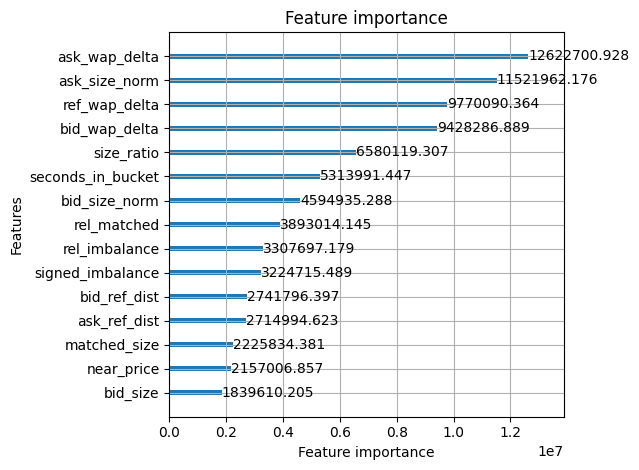

Validation MAE: 5.96642


In [ ]:
train = make_features(train.copy())
drop_cols = ['stock_id', 'date_id', 'time_id', 'row_id']
feature_cols = [c for c in train.columns if c not in drop_cols + ['target']]
train = train[train['target'].notnull()].reset_index(drop=True)
unique_dates = train['date_id'].unique()
split_idx = int(0.8 * len(unique_dates))
train_dates = unique_dates[:split_idx]
valid_dates = unique_dates[split_idx:]
train_mask = train['date_id'].isin(train_dates)
valid_mask = train['date_id'].isin(valid_dates)
X_train = train.loc[train_mask, feature_cols]
y_train = train.loc[train_mask, 'target']
X_valid = train.loc[valid_mask, feature_cols]
y_valid = train.loc[valid_mask, 'target']
categorical_feats = ['imb_side_flag']
train_data = lgbm.Dataset(X_train, label=y_train, categorical_feature=categorical_feats)
valid_data = lgbm.Dataset(X_valid, label=y_valid, categorical_feature=categorical_feats)

params = {
    'objective': 'regression',
    'metric': 'mae',
    'learning_rate': 0.1,
    'num_leaves': 31,
    'verbose': -1,
    'seed': 42,
}

model = lgbm.train(
    params,
    train_data,
    valid_sets=[train_data, valid_data],
    num_boost_round=500,
    callbacks=[
        lgbm.early_stopping(stopping_rounds=20),
        lgbm.log_evaluation(period=50),
    ]
)

lgbm.plot_importance(model, max_num_features=15, importance_type='gain')
plt.tight_layout()
plt.show()

y_pred = model.predict(X_valid, num_iteration=model.best_iteration)
mae = mean_absolute_error(y_valid, y_pred)
print(f"Validation MAE: {mae:.5f}")